In [1]:
! pip install interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 26.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 14.3 MB/s eta 0:00:00
  Created wheel for dash-cytoscape: filename=dash_cytoscape-1.0.2-py3-none-any.whl size=40

In [2]:
import argparse
import os
import random
import joblib
from typing import Tuple, Dict, Any
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression

In [3]:
# InterpretML
from interpret.glassbox import ExplainableBoostingClassifier, ExplainableBoostingRegressor
# Optuna for Bayesian-style optimization
import optuna

# PyTorch for self-supervised pretraining
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


In [4]:
import matplotlib.pyplot as plt
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [5]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [6]:
def equalized_odds_difference(y_true, y_pred_proba, sensitive: np.ndarray, threshold=0.5):
    """Max absolute difference in TPR and FPR across groups (binary sensitive)."""
    preds = (y_pred_proba >= threshold).astype(int)
    groups = np.unique(sensitive)
    tprs = []
    fprs = []
    for g in groups:
        mask = (sensitive == g)
        if mask.sum() == 0:
            tprs.append(0.0)
            fprs.append(0.0)
            continue
        tp = ((y_true == 1) & (preds == 1) & mask).sum()
        fn = ((y_true == 1) & (preds == 0) & mask).sum()
        fp = ((y_true == 0) & (preds == 1) & mask).sum()
        tn = ((y_true == 0) & (preds == 0) & mask).sum()
        tprs.append(tp / (tp + fn) if (tp + fn) > 0 else 0.0)
        fprs.append(fp / (fp + tn) if (fp + tn) > 0 else 0.0)
    # Differences
    tpr_diff = abs(tprs[0] - tprs[1]) if len(tprs) >= 2 else 0.0
    fpr_diff = abs(fprs[0] - fprs[1]) if len(fprs) >= 2 else 0.0
    return max(tpr_diff, fpr_diff)

In [7]:
def empirical_robustness_noise(model_predict_proba, X, y, noise_std_list=[0.01, 0.05, 0.1]):
    """Simple robustness: drop in ROC AUC under additive Gaussian noise."""
    base_auc = roc_auc_score(y, model_predict_proba(X))
    results = {'base_auc': base_auc}
    for std in noise_std_list:
        Xp = X + np.random.normal(0, std, size=X.shape)
        auc = roc_auc_score(y, model_predict_proba(Xp))
        results[f'auc_noise_{std}'] = auc
    return results


In [8]:
from typing import Tuple
import pandas as pd

def load_heart_dataset() -> Tuple[pd.DataFrame, pd.Series]:
    """
    Load the Heart Disease UCI dataset and binarize target.
    Source: https://www.kaggle.com/ronitf/heart-disease-uci
    """
    # Load dataset
    df = pd.read_csv(
        r'/kaggle/input/heart-dataset/heart_disease_uci.csv'
    )
    
    # Features
    X = df.drop(columns=['num','id'])
    
    # Binary labels: 0 stays 0, all others -> 1
    y = (df['num'] > 0).astype(int)

    return X, y


In [9]:
def build_heart_preprocessor(X: pd.DataFrame):
    return FunctionTransformer(lambda x: x)

In [10]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

def format_n(x):
    return "{0:.5f}".format(x)

def train_baseline_ebm_with_vis(X, y, params=None):
    params = params or {}
    model = ExplainableBoostingClassifier(**params)

    ss = StratifiedShuffleSplit(n_splits=3, test_size=0.25, random_state=1337)
    scores = cross_validate(
        model, X, y, scoring='roc_auc', cv=ss,
        n_jobs=None, return_estimator=True, return_train_score=False
    )

    record = dict()
    record['fit_time_mean'] = format_n(np.mean(scores['fit_time']))
    record['fit_time_std'] = format_n(np.std(scores['fit_time']))
    record['test_score_mean'] = format_n(np.mean(scores['test_score']))
    record['test_score_std'] = format_n(np.std(scores['test_score']))

    # Take the first trained model
    trained_model = scores['estimator'][0]

    # Get one split
    train_idx, test_idx = list(ss.split(X, y))[0]

    # Handle pandas vs numpy gracefully
    if hasattr(X, "iloc"):  # Pandas DataFrame
        X_test = X.iloc[test_idx]
    else:  # NumPy array
        X_test = X[test_idx]

    if hasattr(y, "iloc"):  # Pandas Series
        y_test = y.iloc[test_idx]
    else:  # NumPy array
        y_test = y[test_idx]

    # Confusion matrix
    y_pred = trained_model.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title("Confusion Matrix (Validation Split)")
    plt.show()

    # InterpretML visualization
    ebm_global = trained_model.explain_global()
    show(ebm_global)

    return trained_model, record


In [11]:
class TabularAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, max(64, latent_dim * 4)),
            nn.ReLU(),
            nn.Linear(max(64, latent_dim * 4), latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, max(64, latent_dim * 4)),
            nn.ReLU(),
            nn.Linear(max(64, latent_dim * 4), input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z


In [12]:
def pretrain_autoencoder_get_init_scores(X_unlabeled: np.ndarray, X_small_labeled: np.ndarray, y_small: np.ndarray,
                                         device='cpu', epochs=50, batch_size=256, latent_dim=32):
    """
    Train autoencoder on X_unlabeled (self-supervised), then train a small classifier on
    the encoder output for the labeled subset to produce init_score probabilities.
    Returns init_score for entire dataset (probabilities).
    """
    device = torch.device(device)
    X_unlabeled_t = torch.from_numpy(X_unlabeled.astype(np.float32))
    ds = TensorDataset(X_unlabeled_t)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

    ae = TabularAutoencoder(input_dim=X_unlabeled.shape[1], latent_dim=latent_dim).to(device)
    opt = torch.optim.Adam(ae.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for ep in range(epochs):
        ae.train()
        epoch_loss = 0.0
        for (batch,) in dl:
            batch = batch.to(device)
            recon, _ = ae(batch)
            loss = loss_fn(recon, batch)
            opt.zero_grad()
            loss.backward()
            opt.step()
            epoch_loss += loss.item() * batch.size(0)
    # build encoder outputs for labeled small set
    ae.eval()
    with torch.no_grad():
        Z_small = ae.encoder(torch.from_numpy(X_small_labeled.astype(np.float32)).to(device)).cpu().numpy()
        Z_full = ae.encoder(torch.from_numpy(X_unlabeled.astype(np.float32)).to(device)).cpu().numpy()

    # train logistic regression on Z_small -> produce probabilities for full set as init_score
    clf = LogisticRegression(max_iter=1000)
    clf.fit(Z_small, y_small)
    init_scores = clf.predict_proba(Z_full)[:, 1]
    return init_scores, ae, clf

In [13]:
output_dir='out_M_Preprocessing_Heart'
dataset='heart'

In [14]:
DATASET_LOADERS = {
    'heart': load_heart_dataset,
}


In [15]:
def get_heart_data():
    os.makedirs(output_dir, exist_ok=True)
    print(f'[INFO] Loading {dataset} dataset ...')
    X_df, y = DATASET_LOADERS[dataset]()
    preproc = build_heart_preprocessor(X_df)
    X_all = preproc.fit_transform(X_df)
    y = np.asarray(y, dtype=int)
    print("[INFO] Loading completed")

    return X_all,y

[INFO] Training baseline EBM (default params)...
[INFO] Loading heart dataset ...
[INFO] Loading completed


/usr/local/lib/python3.11/dist-packages/interpret/glassbox/_ebm/_ebm.py:869: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]
  warn(
/usr/local/lib/python3.11/dist-packages/interpret/glassbox/_ebm/_ebm.py:869: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]
  warn(
/usr/local/lib/python3.11/dist-packages/interpret/glassbox/_ebm/_ebm.py:869: UserWarning: Missing values detected. Our visualizations do not currently display missing value

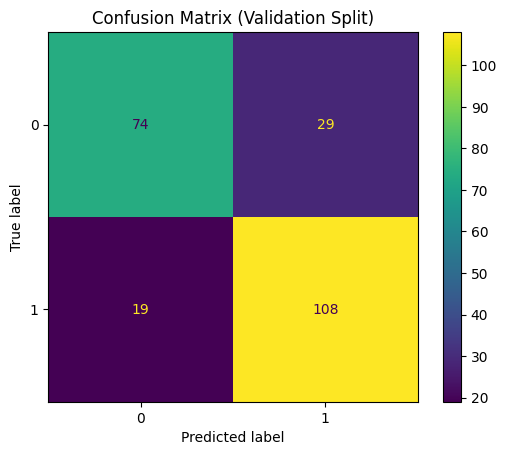

[BASELINE] {'fit_time_mean': '20.68044', 'fit_time_std': '1.42977', 'test_score_mean': '0.88716', 'test_score_std': '0.01091'}


['out_M_Preprocessing_Heart/ebm_baseline.pkl']

In [16]:
# Baseline EBM
print('[INFO] Training baseline EBM (default params)...')
ebm_params = {"random_state": 1337, "n_jobs": -1}
X_all, y = get_heart_data()
ebm, record = train_baseline_ebm_with_vis(X_all, y, params=ebm_params)

print('[BASELINE]', record)

joblib.dump(ebm, os.path.join(output_dir, 'ebm_baseline.pkl'))


[INFO] Training baseline EBM (default params)...
[INFO] Loading heart dataset ...
[INFO] Loading completed


/usr/local/lib/python3.11/dist-packages/interpret/glassbox/_ebm/_ebm.py:869: UserWarning:

Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]

/usr/local/lib/python3.11/dist-packages/interpret/glassbox/_ebm/_ebm.py:869: UserWarning:

Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]

/usr/local/lib/python3.11/dist-packages/interpret/glassbox/_ebm/_ebm.py:869: UserWarning:

Missing values detected. Our visualizations do not currently display missing values. To retai

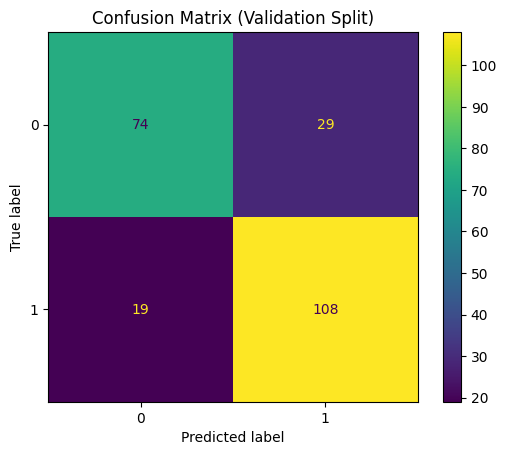

[BASELINE] {'fit_time_mean': '19.86129', 'fit_time_std': '0.35433', 'test_score_mean': '0.88716', 'test_score_std': '0.01091'}


['out_M_Preprocessing_Heart/ebm_baseline.pkl']

In [17]:
# Baseline EBM
print('[INFO] Training baseline EBM (default params)...')
ebm_params = {"random_state": 1337, "n_jobs": -1}
X_all, y = get_heart_data()
ebm, record = train_baseline_ebm_with_vis(X_all, y, params=ebm_params)

print('[BASELINE]', record)

joblib.dump(ebm, os.path.join(output_dir, 'ebm_baseline.pkl'))

In [18]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def run_hpo_ebm_without_dp(X_train, y_train, n_trials=40, timeout=None, output_dir='hpo'):
    os.makedirs(output_dir, exist_ok=True)

    def objective(trial):
        # sample hyperparams
        params = {
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
            'max_bins': trial.suggest_int('max_bins', 64, 512),
            'max_leaves': trial.suggest_int('max_leaves', 2, 64),
            'max_rounds': trial.suggest_int('max_rounds', 50, 2000),
            'interactions': trial.suggest_int('interactions', 0, 10),
            'outer_bags': trial.suggest_int('outer_bags', 4, 32),
            'inner_bags': trial.suggest_int('inner_bags', 0, 8),
            # greedy ratio can be tuned too
            'greedy_ratio': trial.suggest_float('greedy_ratio', 0.0, 20.0),
        }
      

        model = ExplainableBoostingClassifier(**params)
        #model.fit(X_train, y_train)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        roc = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc").mean()
      
        objective_value = (1.0 - roc) 

        # store additional info as trial user attributes
        trial.set_user_attr('roc_auc', roc)
       
        trial.set_user_attr('params', params)
        return objective_value

    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))
    study.optimize(objective, n_trials=n_trials, timeout=timeout)
    # persist study
    joblib.dump(study, os.path.join(output_dir, 'optuna_study_without_dp.pkl'))
    return study


In [19]:
print('[INFO] Running HPO (Optuna)...')
study = run_hpo_ebm_without_dp(X_all, y, n_trials=30, output_dir=output_dir)
print('[HPO] Best trial:', study.best_trial.params)

[I 2025-09-04 18:35:12,604] A new study created in memory with name: no-name-f7ea429a-edb4-496b-a3ee-47521e4d6d61


[INFO] Running HPO (Optuna)...


/tmp/ipykernel_13/3030925094.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/usr/local/lib/python3.11/dist-packages/interpret/glassbox/_ebm/_ebm.py:869: UserWarning:

Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]

/usr/local/lib/python3.11/dist-packages/interpret/glassbox/_ebm/_ebm.py:869: UserWarning:

Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine th

[HPO] Best trial: {'learning_rate': 0.006358358856676255, 'max_bins': 381, 'max_leaves': 3, 'max_rounds': 1942, 'interactions': 9, 'outer_bags': 10, 'inner_bags': 1, 'greedy_ratio': 3.6680901970686763}
